In [41]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
from scipy.stats import itemfreq
import networkx as nx
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 8]


matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['xtick.major.size'] = 9
matplotlib.rcParams['ytick.major.size'] = 9
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4

matplotlib.rcParams['axes.linewidth'] = 2

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['ytick.minor.width'] = 2

matplotlib.rcParams['text.usetex'] = True

import random

from toysimulations import Network

import pickle

In [43]:
INS_DATA_COLUMNS = ['time', 'stoplist_len', 'stoplist_volume', 'rest_stoplist_volume',
                    'pickup_idx', 'dropoff_idx', 'insertion_type', 'pickup_enroute',
                    'dropoff_enroute']

PICKLE_FILE_RING = '../data/ring_100.pkl'
PICKLE_FILE_LINE = '../data/line_100.pkl'
PICKLE_FILE_GRID = '../data/grid_10.pkl'
PICKLE_FILE_TRIGRID = '../data/trigrid_13.pkl'
PICKLE_FILE_STAR = '../data/star_100.pkl'


results = dict()

for topology, pickle_file in zip(['ring', 'line', 'grid', 'trigrid', 'star'],
                                 [PICKLE_FILE_RING, PICKLE_FILE_LINE, PICKLE_FILE_GRID,
                                  PICKLE_FILE_TRIGRID, PICKLE_FILE_STAR]
                                ):
    with open(pickle_file, 'rb') as f:
        results[topology] = pickle.load(f)

In [44]:
!pwd

/home/dmanik/toy-ridesharing/notebooks


In [45]:
from functools import reduce

In [46]:
from scipy import stats

In [47]:
G_ring = nx.cycle_graph(101)
G_line = nx.grid_graph([100,])
G_sq2d = nx.grid_2d_graph(10, 10)
G_tri2d = nx.lattice.triangular_lattice_graph(13, 13)
G_star = nx.star_graph(101)

all_Gs = dict(ring=G_ring, line=G_line, grid=G_sq2d, trigrid=G_tri2d, star=G_star)

# Compute $\alpha$ from data

Remember 

$$
V_{rest} (n) = N-\frac{\alpha}{n}
$$

In [48]:
# First, wrangle the data into pandas dataframes: one for each topology
vol_dfs = []

all_topologies = ('ring', 'line', 'star', 'grid', 'trigrid')
all_Gs = dict(ring=G_ring, line=G_line, grid=G_sq2d, trigrid=G_tri2d, star=G_star)
for topology in all_topologies:
    G = all_Gs[topology]

    result = results[topology]
    x_range = sorted(result.keys())
    
    n_arr = []
    all_dfs = []
    for x in x_range:
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                          columns = INS_DATA_COLUMNS)
        ins_df.loc[:, 'x'] = x
        # cut out transients
        ins_df = ins_df.loc[int(-0.8*len(ins_df)):, :]
        all_dfs.append(ins_df)
    
    master_ins_df = pd.concat(all_dfs)
    
    stoplist_lens = []
    vol_rests = []
    vol_totals = []

    for slen in range(1, max(master_ins_df['stoplist_len'])):
        sel = master_ins_df[master_ins_df['stoplist_len'] == slen]
        stoplist_lens.append(slen)
        vol_rests.append(sel['rest_stoplist_volume'].mean())
        vol_totals.append(sel['stoplist_volume'].mean())
        
    vols_df = pd.DataFrame(data={'stoplist_len': stoplist_lens,
                                 'vol_rest': vol_rests,
                                 'vol': vol_totals}
                              )
    vols_df.loc[:, 'topology'] = topology
    vols_df.loc[:, 'network_size'] = G.number_of_nodes()
    vols_df.set_index('stoplist_len', drop=False, inplace=True, verify_integrity=True)
    vol_dfs.append(vols_df)
    
vols_df = pd.concat(vol_dfs)

In [49]:
# concatenate the dataframes into a single one for convenience
vols_df = pd.concat(vol_dfs, keys=all_topologies)
vols_df.head()

stoplist_len   vol_rest        vol topology  network_size
     stoplist_len                                                           
ring 1                        1   0.000000   0.000000     ring           101
     2                        2   2.377079  18.693292     ring           101
     3                        3   8.773260  37.816606     ring           101
     4                        4  16.494443  51.444931     ring           101
     5                        5  24.091332  62.279394     ring           101

In [50]:
vols_df.loc[['star',], :].tail()

stoplist_len  vol_rest    vol topology  network_size
     stoplist_len                                                      
star 3576                  3576       NaN    NaN     star           102
     3577                  3577     100.0  101.0     star           102
     3578                  3578       NaN    NaN     star           102
     3579                  3579      99.0  101.0     star           102
     3580                  3580       NaN    NaN     star           102

In [51]:
vols_df.loc['line'].tail()

,stoplist_len,vol_rest,vol,topology,network_size
stoplist_len,,,,,
270,270,96.166667,99.333333,line,100
271,271,98.200000,99.200000,line,100
272,272,95.000000,99.000000,line,100
273,273,97.000000,100.000000,line,100
274,274,99.000000,100.000000,line,100


## Compute alpha by curve fitting
Again, $V_{rest} (n) = N\left(1-\frac{\alpha}{n}\right)$. So $\alpha$ can be estimated as the slope between $1-V_{rest}(n)/N$ and $1/n$.

###  First, grid

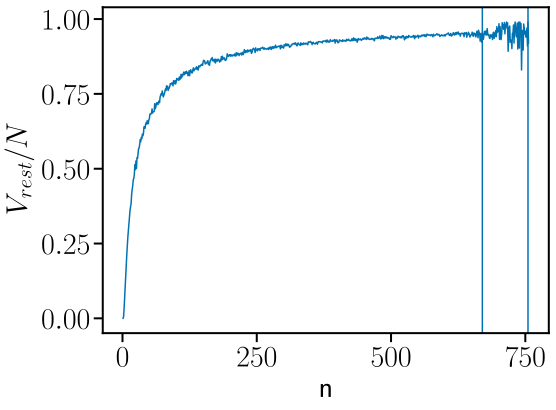

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

topology = 'grid'

sel = vols_df.loc[topology]
ax.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ax.set_xlabel("n")
ax.set_ylabel("$V_{rest}/N$")

ax.axvline(x=670)
ax.axvline(x=755)

We need to be careful while doing our linear fit, because:
* There's significant noise for high $n$.
* The linear approximation doesn't hold for very low $n$ either (at $n\to 0$, the linear relation would predict $V_{rest} \to -\infty$, intead of $0$). So obviously that can't be right.

Therefore before doing the linear fit, we will select only the following subset:
\begin{align}
V_{rest} &> 0.9 N\\
n & < 0.75 \max(n)
\end{align}

In [53]:
from scipy.optimize import curve_fit

####  Strategy for curve fitting

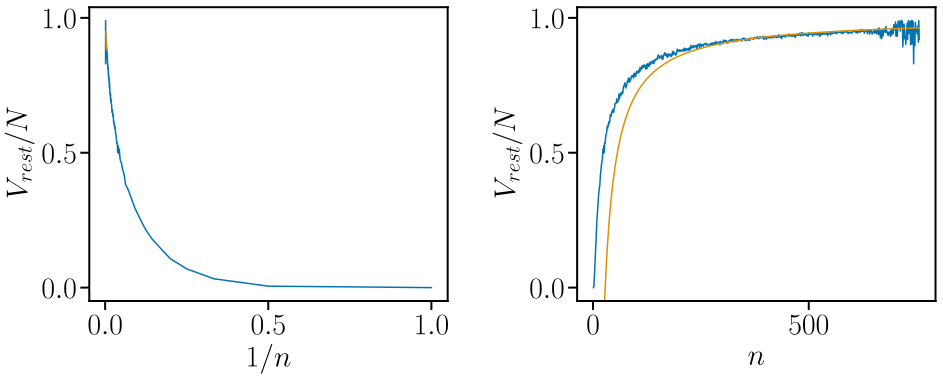

In [54]:
mask = np.logical_and(sel['vol_rest'] > 0.9*sel['network_size'], sel['stoplist_len'] < 0.75*max(sel['stoplist_len']))


x = 1/np.array(sel['stoplist_len'])
y = sel['vol_rest']/sel['network_size']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.plot(x, y)

slope, *_ = curve_fit(lambda x,m:1-m*x, x[mask], y[mask])

ax1.plot(x[mask], 1-slope*x[mask])
ax1.set_xlabel("$1/n$")
ax1.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ylim = ax2.get_ylim()
ax2.set_xlabel("$n$")
ax2.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], 1-slope/sel['stoplist_len'])
ax2.set_ylim(*ylim)

plt.tight_layout()

# store the alpha
alphas_new = dict()
alphas_new[topology] = slope

### Do same stuff for ring

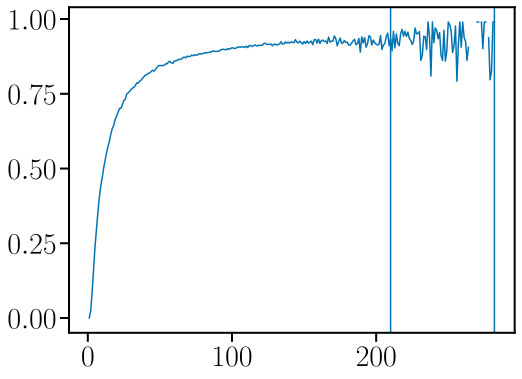

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

topology = 'ring'

sel = vols_df.loc[topology]
ax.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ax.axvline(x=210)
ax.axvline(x=282)

In [56]:
210/282

0.7446808510638298

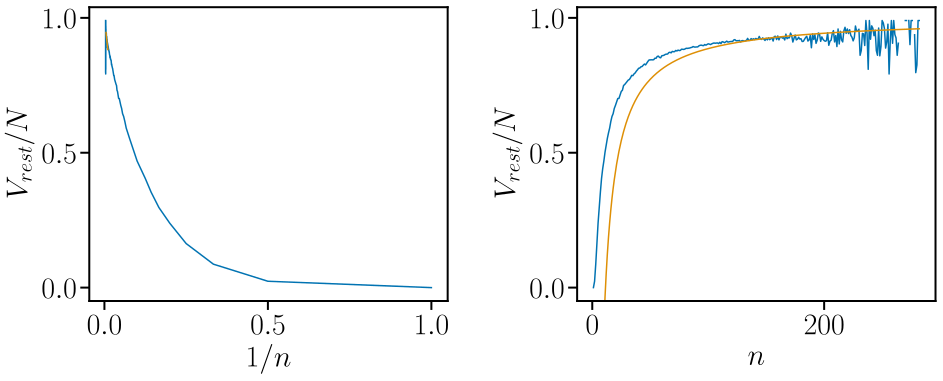

In [57]:
mask = np.logical_and(sel['vol_rest'] > 0.9*sel['network_size'], sel['stoplist_len'] < 0.75*max(sel['stoplist_len']))


x = 1/np.array(sel['stoplist_len'])
y = sel['vol_rest']/sel['network_size']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.plot(x, y)

slope, *_ = curve_fit(lambda x,m:1-m*x, x[mask], y[mask])

ax1.plot(x[mask], 1-slope*x[mask])
ax1.set_xlabel("$1/n$")
ax1.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ylim = ax2.get_ylim()
ax2.set_xlabel("$n$")
ax2.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], 1-slope/sel['stoplist_len'])
ax2.set_ylim(*ylim)

plt.tight_layout()

# store the alpha
alphas_new[topology] = slope

### Do same stuff for star

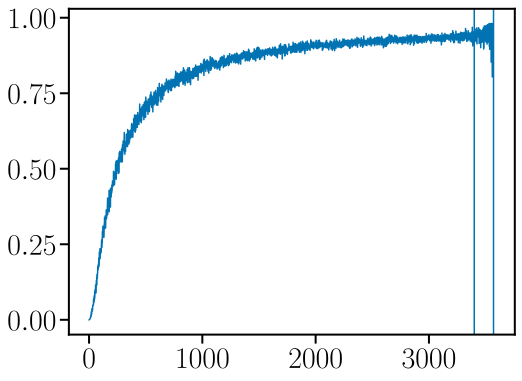

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))

topology = 'star'

sel = vols_df.loc[topology]
ax.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ax.axvline(x=3400)
ax.axvline(x=3570)

In [59]:
3400/3570

0.9523809523809523

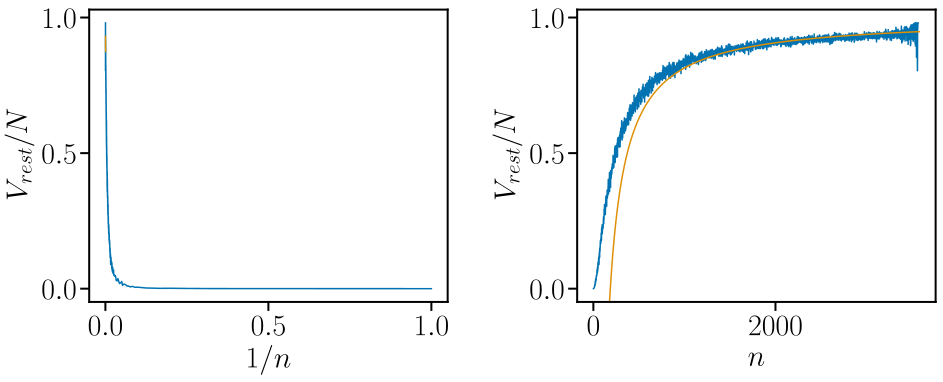

In [60]:
mask = np.logical_and(sel['vol_rest'] > 0.9*sel['network_size'], sel['stoplist_len'] < 0.75*max(sel['stoplist_len']))


x = 1/np.array(sel['stoplist_len'])
y = sel['vol_rest']/sel['network_size']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.plot(x, y)

slope, *_ = curve_fit(lambda x,m:1-m*x, x[mask], y[mask])

ax1.plot(x[mask], 1-slope*x[mask])
ax1.set_xlabel("$1/n$")
ax1.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ylim = ax2.get_ylim()
ax2.set_xlabel("$n$")
ax2.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], 1-slope/sel['stoplist_len'])
ax2.set_ylim(*ylim)

plt.tight_layout()

# store the alpha
alphas_new[topology] = slope

### Line

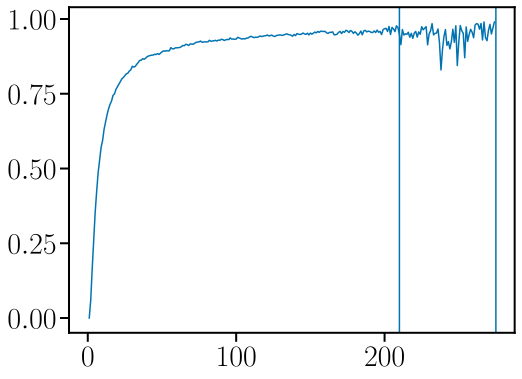

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))

topology = 'line'

sel = vols_df.loc[topology]
ax.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ax.axvline(x=210)
ax.axvline(x=275)

In [62]:
210/275

0.7636363636363637

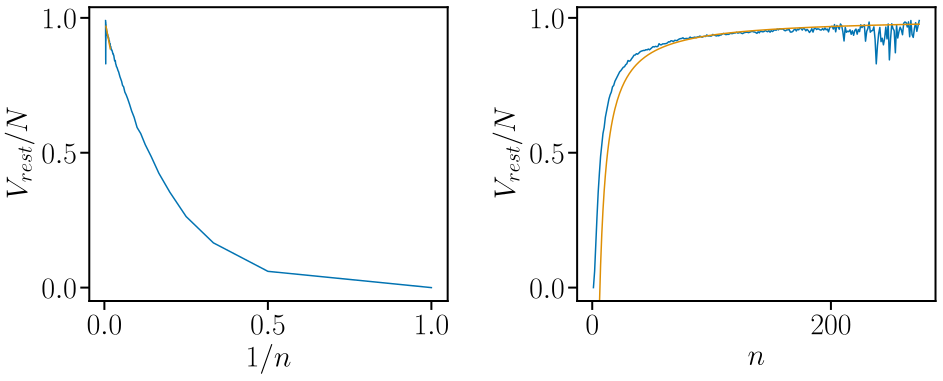

In [63]:
mask = np.logical_and(sel['vol_rest'] > 0.9*sel['network_size'], sel['stoplist_len'] < 0.75*max(sel['stoplist_len']))


x = 1/np.array(sel['stoplist_len'])
y = sel['vol_rest']/sel['network_size']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.plot(x, y)

slope, *_ = curve_fit(lambda x,m:1-m*x, x[mask], y[mask])

ax1.plot(x[mask], 1-slope*x[mask])
ax1.set_xlabel("$1/n$")
ax1.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ylim = ax2.get_ylim()
ax2.set_xlabel("$n$")
ax2.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], 1-slope/sel['stoplist_len'])
ax2.set_ylim(*ylim)

plt.tight_layout()

# store the alpha
alphas_new[topology] = slope

### Trigrid

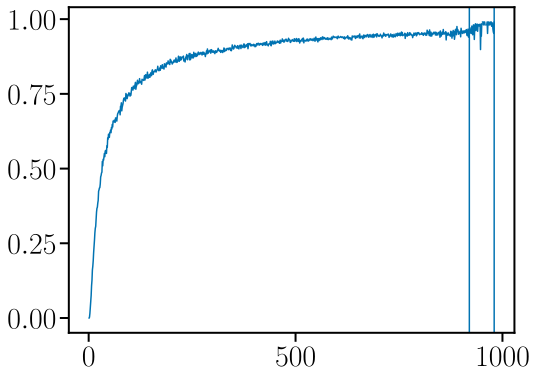

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

topology = 'trigrid'

sel = vols_df.loc[topology]
ax.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ax.axvline(x=980)
ax.axvline(x=920)

In [65]:
920/980

0.9387755102040817

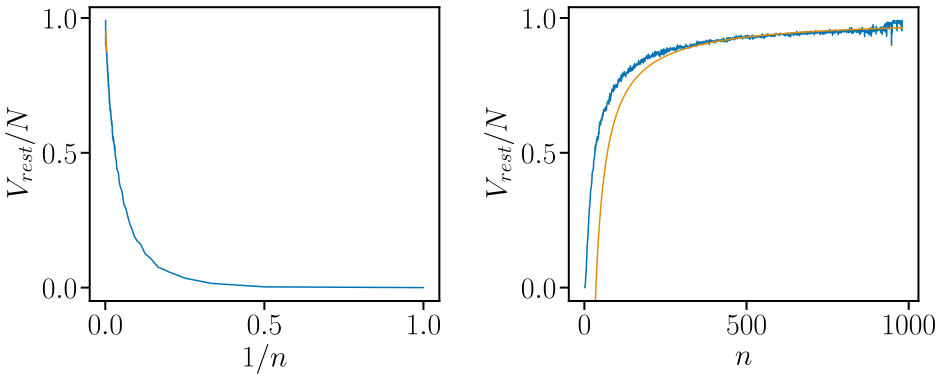

In [66]:
mask = np.logical_and(sel['vol_rest'] > 0.9*sel['network_size'], sel['stoplist_len'] < 0.75*max(sel['stoplist_len']))


x = 1/np.array(sel['stoplist_len'])
y = sel['vol_rest']/sel['network_size']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.plot(x, y)

slope, *_ = curve_fit(lambda x,m:1-m*x, x[mask], y[mask])

ax1.plot(x[mask], 1-slope*x[mask])
ax1.set_xlabel("$1/n$")
ax1.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], sel['vol_rest']/sel['network_size'])

ylim = ax2.get_ylim()
ax2.set_xlabel("$n$")
ax2.set_ylabel("$V_{rest}/N$")

ax2.plot(sel['stoplist_len'], 1-slope/sel['stoplist_len'])
ax2.set_ylim(*ylim)

plt.tight_layout()

# store the alpha
alphas_new[topology] = slope

### Figures together for fitted alpha

In [67]:
alphas_new

{'grid': array([28.24196952]),
 'ring': array([11.38602857]),
 'star': array([186.04320462]),
 'line': array([6.41897059]),
 'trigrid': array([35.45718569])}

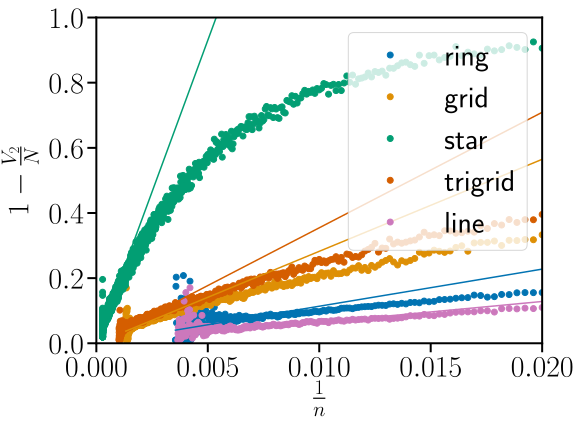

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))


for topology in ('ring', 'grid', 'star', 'trigrid', 'line'):
    sel = vols_df.loc[topology]
    ax.plot(1/sel['stoplist_len'],
            1-sel['vol_rest']/sel['network_size'],
            'o',
            label=topology)
    ax.plot()
    
ax.set_prop_cycle(None)
for topology in ('ring', 'grid', 'star', 'trigrid', 'line'):
    sel = vols_df.loc[topology]
    x = np.array(1/sel['stoplist_len'])
    y = np.array(1-sel['vol_rest']/sel['network_size'])
    
    ax.plot(x, x*alphas_new[topology])
    
ax.set_xlabel(r"$\frac{1}{n}$")
ax.set_ylabel(r"$1-\frac{V_2}{N}$")

ax.set_xlim(0, 0.02)
ax.set_ylim(0,1)
ax.legend()

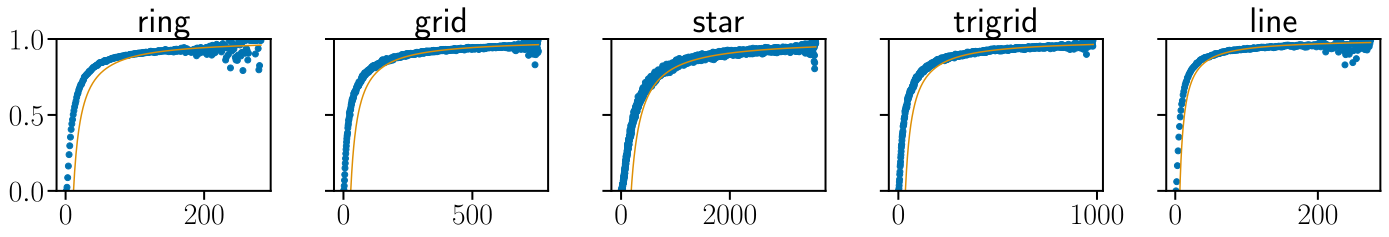

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)


for ax, topology in zip(axes, ('ring', 'grid', 'star', 'trigrid', 'line')):
    sel = vols_df.loc[topology]
    ax.plot(sel['stoplist_len'],
            sel['vol_rest']/sel['network_size'],
            'o',
            label=topology)
    ax.plot()
    
for ax, topology in zip(axes, ('ring', 'grid', 'star', 'trigrid', 'line')):
    sel = vols_df.loc[topology]
    x = np.array(sel['stoplist_len'])
    y = np.array(1-alphas_new[topology]/x)
    
    ax.plot(x,y)
    ax.set_ylim(0,1)
    ax.set_title(topology)

plt.tight_layout()

## Create a function for the alpha curve fit

In [70]:
vols_df.head()

stoplist_len   vol_rest        vol topology  network_size
     stoplist_len                                                           
ring 1                        1   0.000000   0.000000     ring           101
     2                        2   2.377079  18.693292     ring           101
     3                        3   8.773260  37.816606     ring           101
     4                        4  16.494443  51.444931     ring           101
     5                        5  24.091332  62.279394     ring           101

In [71]:
def curve_fit_alpha(data):
    # data has columns: stoplist_len, vol_rest, vol, network_size
    # data should also be sorted by stoplist_len
    mask = np.logical_and(data['vol_rest'] > 0.9*data['network_size'], data['stoplist_len'] < 0.75*max(data['stoplist_len']))

    relevant = data[mask]
    
    mask_nonan = pd.notnull(relevant['vol']) & pd.notnull(relevant['vol_rest']) 
    relevant = relevant.loc[mask_nonan, :]
    
    x = 1/np.array(relevant['stoplist_len'])
    y = relevant['vol_rest']/relevant['network_size']

    [alpha, *_], *_ = curve_fit(lambda x,m:1-m*x, x, y)
    
    return alpha

def alpha_for_topology(topology):
    print(f"Topology: {topology}")
    data =  vols_df.loc[topology]
    return curve_fit_alpha(data)

In [72]:
alpha_systematic_curve_fit = {topo:alpha_for_topology(topo) for topo in all_topologies}
alpha_systematic_curve_fit

Topology: ring
Topology: line
Topology: star
Topology: grid
Topology: trigrid


{'ring': 11.386028572570162,
 'line': 6.41897058532523,
 'star': 186.0432046196512,
 'grid': 28.24196951524343,
 'trigrid': 35.45718568776524}

Now let's see how good this alpha fits with our basic assumption

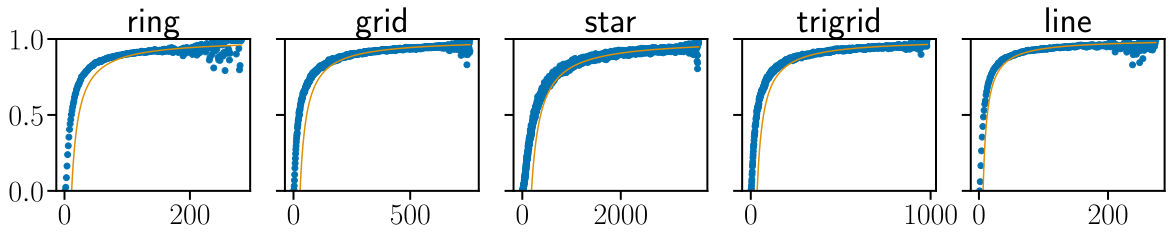

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(17, 4), sharey=True)


for ax, topology in zip(axes, ('ring', 'grid', 'star', 'trigrid', 'line')):
    sel = vols_df.loc[topology]
    ax.plot(sel['stoplist_len'],
            sel['vol_rest']/sel['network_size'],
            'o',
            label=topology)
    ax.plot()
    
for ax, topology in zip(axes, ('ring', 'grid', 'star', 'trigrid', 'line')):
    sel = vols_df.loc[topology]
    x = np.array(sel['stoplist_len'])
    y = np.array(1-alpha_systematic_curve_fit[topology]/x)
    
    ax.plot(x,y)
    ax.set_ylim(0,1)
    ax.set_title(topology)

plt.tight_layout(w_pad=0.1)

### Now, the final figure

In [74]:
def ring_fancy_v_for_n_arr(n_max):
    n = 1
    v_arr = [0]
    
    while n < n_max:
        v = v_arr[-1]
        dv = delta_v(v)
        v_arr.append(v+dv)
        
        n += 1
    return v_arr

from functools import lru_cache

@lru_cache(maxsize=1000)
def ring_fancy_v_for_n(n):
    if n == 0:
        return 0
    else:
        v_prev = ring_fancy_v_for_n(n-1)
        if v_prev <=0.5:
            return v_prev/2 + v_prev**2/3 + 1/4
        else:
            return -1/(4*v_prev) + 5/4 -2*v_prev/3 + 2*v_prev**2/3
        
@lru_cache(maxsize=1000)
def star_v_for_n(n):
    return (1-(1-1/101)**n)

def analytic_v_rest(n, v_func):
    return np.average([v_func(i) for i in range(1, n+1)])

def x_for_n_analytic(n, v_func):
    v = v_func(n)
    v_rest = analytic_v_rest(n, v_func)
    return 2/((1-v_rest)*v+2*(1-v))

In [75]:
vol_funcs = {'ring': ring_fancy_v_for_n, 'star': star_v_for_n}

def make_complex_plot(topology, ax, analytics=False):
    result = results[topology]
    x_range = sorted(result.keys())
    
    
    n_arr = []
    all_dfs = []
    
    for x in x_range:
        # compute n
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)
        n = np.mean(ins_df['stoplist_len'])
        
        n_arr.append(n)
        
    
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)
        ins_df.loc[:, 'x'] = x
        # cut out transients
        ins_df = ins_df.iloc[int(-0.8*len(ins_df)):, :]
        all_dfs.append(ins_df)
    if analytics == False:
        l, = ax.plot(x_range, n_arr, 'o', markersize=5, label=topology, zorder=2, marker='o', linestyle='dashed')
    else:
        l, = ax.plot(x_range, n_arr, label='data', zorder=2, linewidth=4)

    ax.set_xlim(0,40)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$n$")
    
    if analytics == True:
        # now, pure analytics
        _, ymax = ax.get_ylim()
        n_range = range(1, int(ymax))
        vol_func = vol_funcs[topology]
        analytical_x = [x_for_n_analytic(n, vol_func) for n in n_range]
        
        ax.plot(analytical_x, n_range, 'o', label='analytics')
    
        #lt.legend(fontsize=15)
        #lt.xlim(0,40)
        #lt.ylim(0,250)
    return l

/home/dmanik/toy-ridesharing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


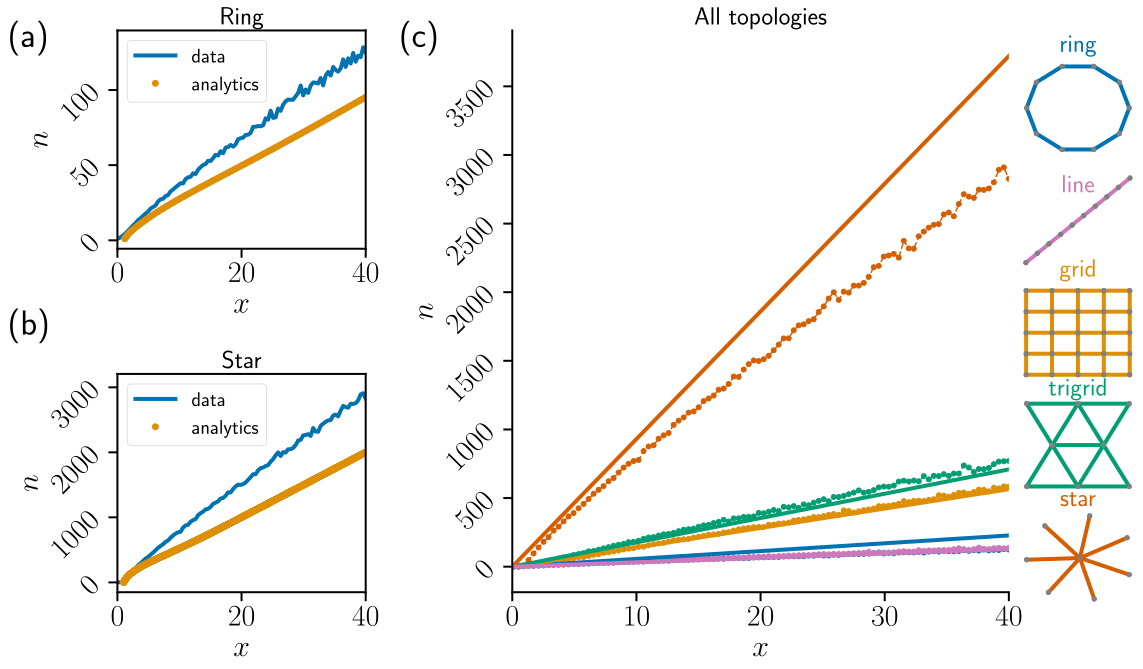

In [76]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors
fig = plt.figure(figsize=(16, 10))

#fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
EXTENT_MAINPLOT = 0.93
gs1 = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1], left=0, right=EXTENT_MAINPLOT)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])
ax3 = fig.add_subplot(gs1[:, 1])

gs2 = fig.add_gridspec(5, 1, left=0.9, right=1.0, hspace=0.2)
# Plot stuff
# ax1: ring
make_complex_plot('ring', ax1, analytics=True)
ax1.set_title('Ring', fontsize=25)
ax1.legend(fontsize=20, framealpha=0.6)
# ax2: star
make_complex_plot('star', ax2, analytics=True)
ax2.set_title('Star', fontsize=25)
ax2.legend(fontsize=20, framealpha=0.6)
# ax3: all together

topologies_ordered = ('ring', 'grid', 'trigrid', 'star',  'line')
topo_line_map = dict()
for topology in topologies_ordered:
    line = make_complex_plot(topology, ax3)
    topo_line_map[topology] = line
    pass
    
# now, alpha with v2
ax3.set_prop_cycle(None)
topo_color_mapping = {}
for topology in topologies_ordered:
    alpha = alpha_systematic_curve_fit[topology]
    x_arr = np.linspace(0,40,10)
    y_arr = alpha/2*x_arr
    l, = ax3.plot(x_arr, y_arr, '-', linewidth=4)
    topo_color_mapping[topology] = colors.to_hex(l.get_c())
        
ax3.set_title('All topologies', fontsize=25)

# legend
#legend_order = ['ring', 'line', 'grid', 'trigrid', 'star']
#ax3.legend([topo_line_map[t] for t in legend_order], legend_order, fontsize=20)

# aesthetics
ax2.set_yticks([0, 1000, 2000, 3000])

#ax3.yaxis.tick_right()
for ax in (ax1, ax2, ax3):
    ax.yaxis.set_tick_params(rotation=45)

# letter as subfigure captions
fig.text(0.02, 0.9, '(a)', fontsize=35, transform=fig.transFigure)
fig.text(0.36, 0.9, '(c)', fontsize=35, transform=fig.transFigure)
fig.text(0.02, 0.5, '(b)', fontsize=35, transform=fig.transFigure)




# plot network motifs
graph_drawing_kwargs = dict(with_labels=False, node_size=20, node_color='gray', width=4)
nxaxes = [fig.add_subplot(gs2[i]) for i in range(5)]

legend_order = ['ring', 'line', 'grid', 'trigrid', 'star']

# ring
sample_ring = nx.cycle_graph(n = 10)
layout_ring = nx.layout.circular_layout(sample_ring)
nax = nxaxes[0]
nax.axis('off')
color = topo_color_mapping['ring']
nax.text(x=0.5, y=1.1, horizontalalignment='center', s="ring", fontsize=25, color=color, transform=nax.transAxes)
nx.draw_networkx(sample_ring, pos=layout_ring, ax=nax, edge_color=color, **graph_drawing_kwargs)

# line
sample_line = nx.grid_graph([10,])
layout_line = {n:(n, n) for n in sample_line.nodes()}
nax = nxaxes[1]
nax.axis('off')
color = topo_color_mapping['line']
nax.text(x=0.5, y=0.8, horizontalalignment='center', s="line", fontsize=25, color=color, transform=nax.transAxes)
nx.draw_networkx(sample_line, pos=layout_line, ax=nax, edge_color=color, **graph_drawing_kwargs)

# grid
sample_grid = nx.grid_graph([5,5])
layout_grid = {n:n for n in sample_grid.nodes()}
nax = nxaxes[2]
nax.axis('off')
color = topo_color_mapping['grid']
nax.text(x=0.5, y=1.1, horizontalalignment='center', s="grid", fontsize=25, color=color, transform=nax.transAxes)
nx.draw_networkx(sample_grid, pos=layout_grid, ax=nax, edge_color=color, **graph_drawing_kwargs)

# trigrid
sample_trigrid = nx.lattice.triangular_lattice_graph(2, 3)
layout_trigrid = {n:sample_trigrid.node[n]['pos'] for n in sample_trigrid.nodes()}
nax = nxaxes[3]
nax.axis('off')
color = topo_color_mapping['trigrid']
nax.text(x=0.5, y=1.03, horizontalalignment='center', s="trigrid", fontsize=25, color=color, transform=nax.transAxes)
nx.draw_networkx(sample_trigrid, pos=layout_trigrid, ax=nax, edge_color=color, **graph_drawing_kwargs)


# star
sample_star = nx.star_graph(n=7)
layout_star = {n:(n,0) for n in sample_star.nodes()}
nax = nxaxes[4]
nax.axis('off')
color = topo_color_mapping['star']
nax.text(x=0.5, y=1.05, horizontalalignment='center', s="star", fontsize=25, color=color, transform=nax.transAxes)
nx.draw_networkx(sample_star, pos=nx.spring_layout(sample_star), ax=nax, edge_color=color, **graph_drawing_kwargs)


ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# fine adjustments to the layout
gs1.tight_layout(fig, rect=[0,0,EXTENT_MAINPLOT,1])

fig.savefig('n_vs_x_w_analytics.pdf', bbox_inches='tight')